In [21]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import copy
import time
import pickle
import os.path

from utils import *
from Environment import Environment
from Model import QNetwork

# set np seed
np.random.seed(0)

logger = Logger("test.txt")

In [2]:
# def sample_priorities(env, close_pairs, preds, policy='stochastic'):
#     partial_prio = dict()
#     pred_value = dict()
#     predictions = dict()
#     probabilities = dict()

#     # Sample an praction based on the probabilities
#     probs = F.softmax(preds, dim=1)

#     if policy == 'stochastic':
#         actions = torch.multinomial(probs, 1)
#     elif policy == 'random':
#         actions = torch.randint(0, 2, (len(close_pairs), 1))
#     elif policy == 'greedy':
#         actions = torch.argmax(preds, dim=1).view(-1, 1)

#     for i, (agent, neighbor) in enumerate(close_pairs):
#         predictions[(agent, neighbor)] = preds[i]
#         probabilities[(agent, neighbor)] = probs[i]
#         pred_value[(agent, neighbor)] = preds[i][actions[i]]
#         partial_prio[(agent, neighbor)] = actions[i]

#     previous_three_flipped = [(-1, -1), (-1, -1), (-1, -1)]

#     # while there is a cycle
#     start_time = time.time()
#     priorities, cycle = topological_sort(
#         partial_prio, num_nodes=env.num_agents).values()
#     if cycle:
#         logger.print("Cycle exists")
#     while cycle:
#         # if there is a cycle, break the cycle by flipping the priority of the edge with the lowest confidence to 0
#         min_confidence = float('inf')
#         min_pair = None
#         cycle = sorted(cycle, key=lambda x: len(x[0]), reverse=True)[0]
#         # cycle_edges = [tuple(sorted(t)) for t in cycle[1]]
#         cycle_set = [set(c) for c in cycle[1]]
#         cycle_edges = []
#         for pairs in close_pairs:
#             if set(pairs) in cycle_set:
#                 cycle_edges.append(pairs)
#         # logger.print cycle_edges and their predictions
#         logger.print("edges, prio, probs")
#         for c in cycle_edges:
#             partial_prio[c].item()
#             round(probabilities[c][partial_prio[c]].item(), 3)
#             logger.print(c, partial_prio[c].item(),
#                    round(probabilities[c][partial_prio[c]].item(), 3))
#         for pair, confidence in probabilities.items():
#             if pair in cycle_edges and confidence[partial_prio[pair]] < min_confidence:
#                 min_confidence = confidence[partial_prio[pair]]
#                 min_pair = pair
#         logger.print("flip", min_pair, "from",
#                partial_prio[min_pair].item(), "to", 1-partial_prio[min_pair].item())

#         # TODO: WRONG
#         # it wont flip the same edge twice
#         # but need to check if flip back and forth
#         # sample new pairwise priorities
#         if min_pair == previous_three_flipped[-2] and previous_three_flipped[-1] == previous_three_flipped[-3]:
#             actions = torch.multinomial(probs, 1)
#             for i, (agent, neighbor) in enumerate(close_pairs):
#                 predictions[(agent, neighbor)] = preds[i]
#                 probabilities[(agent, neighbor)] = probs[i]
#                 pred_value[(agent, neighbor)] = preds[i][actions[i]]
#                 partial_prio[(agent, neighbor)] = actions[i]
#             previous_three_flipped = [(-1, -1), (-1, -1), (-1, -1)]
#         else:
#             previous_three_flipped.append(min_pair)
#             partial_prio[min_pair] = 1-partial_prio[min_pair]
#             pred_value[min_pair] = predictions[min_pair][partial_prio[min_pair]]
#             # set probability of min_pair to 1 to avoid further flipping
#             probabilities[min_pair][partial_prio[min_pair]] = 1

#         priorities, cycle = topological_sort(
#             partial_prio, num_nodes=env.num_agents).values()

#     logger.print("Time to resolve cycles:", round(time.time()-start_time, 3))

#     # TODO: if after 1000 iterations, cycle still exists even after resampling partial prio, then return None and sample random prio and move on to next instance

#     return priorities, partial_prio, pred_value


Environment.__init__: loading heuristic map from file


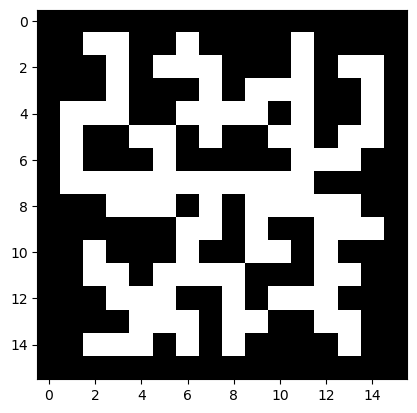

In [2]:
# %%
# INITIALIZE ENVIRONMENT
size = 14
num_agents = 4
obstacle_density = 0.5
fov = 7
window_size = 3

env = Environment(size=size, num_agents=num_agents, obstacle_density=obstacle_density, fov=fov, window_size=window_size, logger=logger)

i = 0
throughput = []

plt.imshow(env.grid_map, cmap='gray_r')


In [3]:
# CREATE TESTING SET
# save start, goal locations

num_agents = 15
filename = f'./testing_set/test_set_{num_agents}_1.pickle'

if not os.path.exists(filename):
    num_instances = 1000
    start_locations = []
    goal_locations = []
    for i in range(num_instances):
        env.reset(num_agents=num_agents)
        start_locations.append(copy.deepcopy(env.starts))
        goal_locations.append(copy.deepcopy(env.goals))

    test_set = {'start_locations': start_locations, 'goal_locations': goal_locations}

    with open(filename, 'wb') as handle:
        pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)



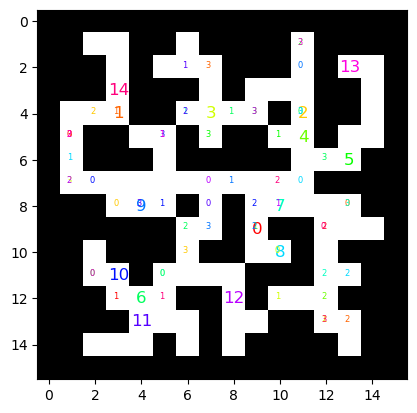

In [4]:
env.reset(num_agents=15)
filename = f'./testing_set/test_set_{num_agents}_1.pickle'

with open(filename, 'rb') as handle:
    test_set = pickle.load(handle)

start_locations = test_set['start_locations']
goal_locations = test_set['goal_locations']

idx = 0

env.starts = start_locations[idx]
env.goals = goal_locations[idx]

env.show_current_state()

In [5]:
# checkpoint = torch.load("./q_net_model/q_net_167500.pth")
# for i in list(checkpoint.keys()):
#     print(i, checkpoint[i].shape)

In [22]:
q_net = QNetwork()
# load the model
q_net.load_state_dict(torch.load('./q_net_model/q_net_185000.pth'))
# q_net.eval()
# q_net.train()

<All keys matched successfully>

In [26]:
# TEST MODEL ON TEST SET
USE_MODEL = False

logger.reset()
throughput = []
for idx in range(1000):
    logger.print("Step", idx, "\n")
    
    solved = False
    start_time = time.time()
    env.starts = start_locations[idx].copy()
    env.goals = goal_locations[idx].copy()

    obs_fovs = env.get_obs()

    # get close pairs
    close_pairs = env.get_close_pairs()

    if close_pairs == []:
        logger.print("No close pairs, skipping instance\n")
        continue

    # USE MODEL
    if USE_MODEL:
        pair_enc, q_vals = q_net(obs_fovs.unsqueeze(0), [close_pairs])
        # sample priorities
        priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='greedy')
        new_start = None
        if priorities:
            new_start, new_goals = env.step(priorities)
            if new_start is not None:
                solved = True
        if priorities is None or new_start is None:
            logger.print("greedy policy failed, switching to stochastic policy")
            while time.time() - start_time < 10:
                priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')
                
                new_start, new_goals = env.step(priorities)
                if new_start is not None:
                    solved = True
                    break
    else:
        # RANDOM PRIORITIES
        while time.time() - start_time < 10:
            # random priority
            priorities = list(range(num_agents))
            np.random.shuffle(priorities)
            new_start, new_goals = env.step(priorities)
            if new_start is not None:
                solved = True
                break

    if not solved:
        logger.print("Could not solve instance")
        throughput.append(0)
    else:
        throughput.append(env.goal_reached)
        logger.print("Priority ordering:", priorities, "\n")
        logger.print("Time to solve instance:", round(time.time()-start_time, 3))
        # global reward from sum of delays
        global_reward = sum([-x for x in env.get_delays()])

        if idx % 100 == 0:
            # save plot of throughput
            plt.plot(throughput)
            # plot running average
            plt.plot(np.convolve(throughput, np.ones(100)/100, mode='valid'))
            plt.savefig("throughput_plot.png")
            plt.ylabel("Throughput")
            plt.xlabel("Steps")
            plt.close()

Step 0 

Priority ordering: [9, 7, 14, 12, 10, 6, 1, 8, 13, 3, 11, 5, 2, 0, 4] 

Time to solve instance: 0.08
Step 1 

Priority ordering: [7, 14, 0, 5, 9, 2, 8, 10, 13, 11, 4, 3, 6, 12, 1] 

Time to solve instance: 0.129
Step 2 

Priority ordering: [2, 7, 4, 0, 6, 11, 5, 10, 9, 12, 1, 8, 3, 13, 14] 

Time to solve instance: 0.108
Step 3 

Priority ordering: [6, 5, 11, 3, 9, 4, 14, 0, 2, 8, 12, 1, 13, 10, 7] 

Time to solve instance: 0.116
Step 4 

Priority ordering: [9, 10, 6, 0, 14, 12, 1, 8, 5, 7, 4, 3, 13, 2, 11] 

Time to solve instance: 0.136
Step 5 

Priority ordering: [9, 11, 7, 6, 13, 8, 3, 5, 14, 2, 0, 12, 10, 4, 1] 

Time to solve instance: 0.1
Step 6 

Priority ordering: [14, 8, 4, 12, 6, 7, 0, 3, 1, 11, 13, 10, 5, 2, 9] 

Time to solve instance: 0.104
Step 7 

Priority ordering: [11, 9, 10, 0, 14, 5, 7, 12, 6, 1, 3, 4, 2, 8, 13] 

Time to solve instance: 0.078
Step 8 

Priority ordering: [1, 4, 14, 9, 2, 11, 0, 13, 12, 10, 8, 7, 3, 5, 6] 

Time to solve instance: 0.105
Step

In [27]:
# model_throughput = np.mean(throughput)
random_throughput = np.mean(throughput)

In [28]:
# average throughput of QTRAN-alt model over 1000 instances in test_set_15_1
round(model_throughput, 3), round(random_throughput, 3)

(1.138, 1.148)

In [16]:
# MODEL: average throughput of QTRAN-alt model over 1000 instances in test_set_1
round(np.mean(throughput), 3)

1.166

In [14]:
# RANDOM: average throughput of random over 1000 instances in test_set_1
round(np.mean(throughput), 3)

1.139

In [12]:
# SIMULATE LMAPF

i = 0
new_start, new_goals = env.starts, env.goals

while i < 200:
    timestep_start = time.time()
    logger.print("Step", i, "\n")
    i += 1

    # get observation FOVs
    obs_fovs = env.get_obs_fov(new_start, new_goals)
    obs_fovs = torch.where(torch.isinf(obs_fovs), torch.tensor(-1), obs_fovs)

    # GATHER PAIRS OF 'CLOSE' AGENTS
    close_pairs = env.get_close_pairs()

    if close_pairs == []:
        logger.print("No close pairs, skipping instance\n")
        # _, _, _, new_start, new_goals = step(env, None, random=True)
        priorities = list(range(env.num_agents))
        new_start, new_goals = env.step(priorities)
        continue

    # feed to model to get q_val
    pair_enc, q_vals = q_net(obs_fovs.unsqueeze(0), [close_pairs])
    logger.print("Q_vals:")
    for pair, qval in zip(close_pairs, q_vals[0]):
        logger.print(pair, np.round(qval.detach().numpy().squeeze(), 3))
    logger.print()

    priorities, partial_prio, pred_value = sample_priorities(
        env, close_pairs, q_vals[0], policy='greedy')
    start_time = time.time()
    new_start, new_goals = env.step(priorities)
    logger.print("Time to env.step:", round(time.time()-start_time, 3))
    if new_start is None:
        logger.print("Greedy Priorities not feasible, sample stochastically\n")
        tries = 0
        while tries < 100:
            priorities, partial_prio, pred_value = sample_priorities(
                env, close_pairs, q_vals[0], policy='stochastic')
            # print time it takes to take step in env (A* planning)
            start_time = time.time()
            new_start, new_goals = env.step(priorities)
            logger.print("Time to env.step:", round(time.time()-start_time, 3))
            if new_start is not None:
                break
            logger.print("Stochastic Priorities not feasible, resampling Stochastically\n")
            tries += 1

    tries = 0
    if new_start is None:
        logger.print("Stochastic Priorities not feasible, sample randomly\n")
        while tries < 100:
            priorities, partial_prio, pred_value = sample_priorities(
                env, close_pairs, q_vals[0], policy='random')
            # print time it takes to take step in env (A* planning)
            start_time = time.time()
            new_start, new_goals = env.step(priorities)
            logger.print("Time to env.step:", round(time.time()-start_time, 3))
            if new_start is not None:
                break
            logger.print("Random Priorities not feasible, resampling Randomly\n")
            tries += 1

    if new_start is None:
        logger.print("instance not solvable, skipping instance\n")
        env.reset()
        new_start, new_goals = env.starts, env.goals
        continue

    throughput.append(env.goal_reached)
    
    logger.print("Priority ordering:", priorities, "\n")

    logger.print("Time to solve instance:", round(time.time()-timestep_start, 3))

    # global reward from sum of delays
    global_reward = sum([-x for x in env.get_delays()])


    if i % 100 == 0:
        # save plot of throughput
        plt.plot(throughput)
        # plot running average
        plt.plot(np.convolve(throughput,
                    np.ones(100)/100, mode='valid'))
        plt.savefig("throughput_plot.png")
        plt.ylabel("Throughput")
        plt.xlabel("Steps")
        plt.close()

    logger.print("____________________________________________________________________________")

Step 0 

Q_vals:
 [[ 0.452  0.847]
 [-0.45  -0.061]
 [-0.066 -0.073]
 [ 0.462  0.412]
 [-0.505 -0.526]
 [ 0.17   0.1  ]
 [-0.64  -0.658]
 [ 0.512  0.525]
 [-0.242  0.297]] 

Time to resolve cycles: 0.0
st_astar: No path found (3, 14) (1, 11)
Time to env.step: 0.032
Greedy Priorities not feasible, sample stochastically

Cycle exists
edges, prio, probs
(0, 3) 0 0.403
(0, 5) 1 0.596
(3, 5) 0 0.497
flip (0, 3) from 0 to 1
edges, prio, probs
(1, 4) 0 0.512
(1, 6) 1 0.495
(4, 6) 0 0.368
flip (4, 6) from 0 to 1
Time to resolve cycles: 0.001
st_astar: No path found (1, 3) (4, 7)
Time to env.step: 0.019
Priorities not feasible, resampling

Cycle exists
edges, prio, probs
(0, 3) 0 0.403
(0, 5) 1 0.596
(3, 5) 0 0.497
flip (0, 3) from 0 to 1
Time to resolve cycles: 0.001
st_astar: No path found (1, 3) (4, 7)
Time to env.step: 0.014
Priorities not feasible, resampling

Cycle exists
edges, prio, probs
(1, 2) 1 0.498
(1, 6) 0 0.505
(2, 6) 1 0.496
flip (2, 6) from 1 to 0
Time to resolve cycles: 0.001


(0, 1) [-0.104  0.059] [0.459 0.541]
(0, 2) [-0.655 -0.676] [0.505 0.495]
(0, 3) [-0.243 -0.32 ] [0.519 0.481]
(1, 2) [ 0.038 -0.06 ] [0.524 0.476]
(1, 3) [ 0.133 -0.125] [0.564 0.436]
(2, 3) [-0.552 -0.676] [0.531 0.469]
priorities [1, 0, 2, 3]
Global Reward: -7


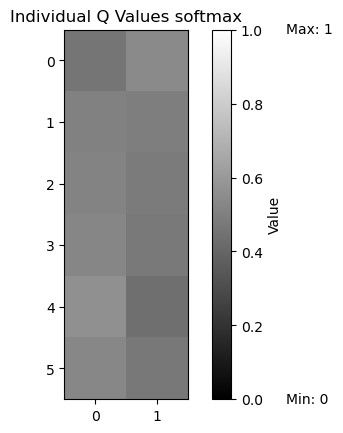

In [7]:
# OVERFIT TEST
env.reset(num_agents=4)

FIXED_START = [(11, 5), (11, 6), (11, 7), (13, 5)]
FIXED_GOALS = [[(12, 3), (10, 2), (1, 2)],
               [(11, 7), (13, 8), (1, 2)],
               [(12, 5), (14, 6), (1, 2)],
               [(11, 6), (9, 7), (1, 2)]]

# FORCE START AND GOAL LOCATION
new_start, new_goals = copy.deepcopy(FIXED_START), copy.deepcopy(FIXED_GOALS)
env.starts, env.goals = new_start, new_goals

# get observation FOVs
obs_fovs = env.get_obs_fov(new_start, new_goals)
obs_fovs = torch.where(torch.isinf(obs_fovs), torch.tensor(-1), obs_fovs)

# form list of close agents
close_pairs = env.get_close_pairs()

# feed to model to get q_val
pair_enc, q_vals = q_net(obs_fovs.unsqueeze(0), [close_pairs])

plt.imshow(F.softmax(q_vals[0], dim=1).detach().numpy(), vmin=0, vmax=1, cmap='gray')
# print Q values for each pair
cbar = plt.colorbar()
cbar.set_label('Value')  # Label for the colorbar
# Annotate the colorbar with min and max values
cbar.ax.text(4, 0, f"Min: 0", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
cbar.ax.text(4, 1, f"Max: 1", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
plt.title("Individual Q Values softmax")
plt.savefig("indiv_q_vals_alt.png")

for p, q in zip(close_pairs, np.array([np.round(i.detach().numpy().squeeze(), 3) for i in q_vals][0])):
    print(p, q, np.round(F.softmax(torch.tensor(q), dim=0).detach().numpy().squeeze(), 3))

priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='greedy')
if priorities is None:
    priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')

tries = 0
while tries < 10:
    new_start, new_goals = env.step(priorities)
    if new_start is not None:
        break
    priorities, partial_prio, pred_value = sample_priorities(env, close_pairs, q_vals[0], policy='stochastic')
    tries += 1

print("priorities", priorities)

# global reward from sum of delays
global_reward = sum([-x for x in env.get_delays()])

print("Global Reward:", global_reward)

(1, 0) [ 0.058 -0.05 ] [0.527 0.473]
(2, 0) [-0.62  -0.512] [0.473 0.527]
(3, 0) [-0.327 -0.221] [0.474 0.526]
(2, 1) [-0.189 -0.063] [0.469 0.531]
(3, 1) [-0.266 -0.005] [0.435 0.565]
(3, 2) [-0.782 -0.599] [0.454 0.546]
priorities [1, 0, 2, 3]
Global Reward: -7


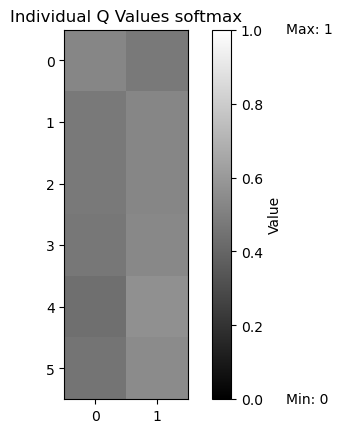

In [8]:
# OVERFIT TEST
env.reset(num_agents=4)

FIXED_START = [(11, 5), (11, 6), (11, 7), (13, 5)]
FIXED_GOALS = [[(12, 3), (10, 2), (1, 2)],
               [(11, 7), (13, 8), (1, 2)],
               [(12, 5), (14, 6), (1, 2)],
               [(11, 6), (9, 7), (1, 2)]]

# FORCE START AND GOAL LOCATION
new_start, new_goals = copy.deepcopy(FIXED_START), copy.deepcopy(FIXED_GOALS)
env.starts, env.goals = new_start, new_goals

# get observation FOVs
obs_fovs = env.get_obs_fov(new_start, new_goals)
obs_fovs = torch.where(torch.isinf(obs_fovs), torch.tensor(-1), obs_fovs)

# form list of close agents
close_pairs = env.get_close_pairs()
close_pairs = [(x[1], x[0]) for x in close_pairs]

# feed to model to get q_val
pair_enc, q_vals = q_net(obs_fovs.unsqueeze(0), [close_pairs])

plt.imshow(F.softmax(q_vals[0], dim=1).detach().numpy(), vmin=0, vmax=1, cmap='gray')
# print Q values for each pair
cbar = plt.colorbar()
cbar.set_label('Value')  # Label for the colorbar
# Annotate the colorbar with min and max values
cbar.ax.text(4, 0, f"Min: 0", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
cbar.ax.text(4, 1, f"Max: 1", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
plt.title("Individual Q Values softmax")
plt.savefig("indiv_q_vals_alt.png")

for p, q in zip(close_pairs, np.array([np.round(i.detach().numpy().squeeze(), 3) for i in q_vals][0])):
    print(p, q, np.round(F.softmax(torch.tensor(q), dim=0).detach().numpy().squeeze(), 3))

priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='greedy')
if priorities is None:
    priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')

tries = 0
while tries < 10:
    new_start, new_goals = env.step(priorities)
    if new_start is not None:
        break
    priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')
    tries += 1

print("priorities", priorities)

# global reward from sum of delays
global_reward = sum([-x for x in env.get_delays()])

print("Global Reward:", global_reward)